## imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import Subset
import multiprocessing


In [2]:
from spoofdet import config

from spoofdet.efficient_net.model_utils import get_transform_pipeline, evaluate_model, train_model, check_image, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution, display_params, verify_subject_split, get_model, get_data_for_training
from spoofdet.dataset import CelebASpoofDataset

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## params


In [4]:
import multiprocessing
from torch.utils.data import Subset

PARAM_MULTIPLIER = 1

MODEL_NAME = "efficientnet_v2_s"
BATCH_SIZE= 32 * PARAM_MULTIPLIER


EPOCHS = 100
EARLY_STOPPING_LIMIT = config.EARLY_STOPPING_LIMIT
TARGET_SIZE = 384
#TARGET_SIZE = config.TARGET_SIZE
LEARNING_RATE = 1e-3 * PARAM_MULTIPLIER

BACKBONE_LR = 1e-5
HEAD_LR = 1e-3  
WEIGHT_DECAY = 5e-2 * PARAM_MULTIPLIER


NUM_UNFROZEN_LAYERS = 3



WORKERS = 2

SPOOF_PERCENT = 0.5
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.2)  
# VAL_IMG_COUNT = 1000
TEST_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  
    # 0.001


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bbox_lookup = "../bbox_lookup.json"
num_cpus = multiprocessing.cpu_count()
criterion = nn.CrossEntropyLoss()
device

device(type='cuda')

In [11]:
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [12]:
train_dict, val_ds = get_data_for_training(json_path=config.TRAIN_JSON, spoof_percent=SPOOF_PERCENT, train_count=TRAIN_IMG_COUNT, val_count=VAL_IMG_COUNT)

train_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=train_dict,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

val_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=val_ds,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)   
test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)


# t_idx, v_idx = split_celeba_json_by_subject(config.TRAIN_JSON)
# train_ds = Subset(all_ds, t_idx)
# val_ds = Subset(all_ds, v_idx)

Total training images: 494405
Subjects: 8192 total, 6553 train, 1639 val
Images: 395427 train, 98978 val
Subject-split - Train: 395427, Val: 98978
Training set: 10000 images
  Live: 5000 (50.0%)
  Spoof: 5000 (50.0%)
Validation set: 2000 images
  Live: 1000 (50.0%)
  Spoof: 1000 (50.0%)
Loading BBox Cache into RAM...
Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [13]:

np.random.seed(seed)

# small_train_ds = create_subset(train_ds.dataset, total_size=TRAIN_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
# small_val_ds = create_subset(val_ds.dataset, total_size=VAL_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=TEST_IMG_COUNT)
print(f"Created Balanced Test: {len(small_test_ds)} images")

 Scanning specific indices for class balance...
 Found in this split: 19923 Live | 47247 Spoof
Created Balanced Test: 1000 images


In [15]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=WORKERS,
                              pin_memory=True,
                              persistent_workers=True
                

)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [16]:
model = get_model()
model_path = "train_results/train_15/model.pt"
state_dict = torch.load(model_path)
print(type(model))

<class 'torchvision.models.efficientnet.EfficientNet'>


In [17]:
model.load_state_dict(state_dict)
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           497     |          3
Spoof          144     |        356


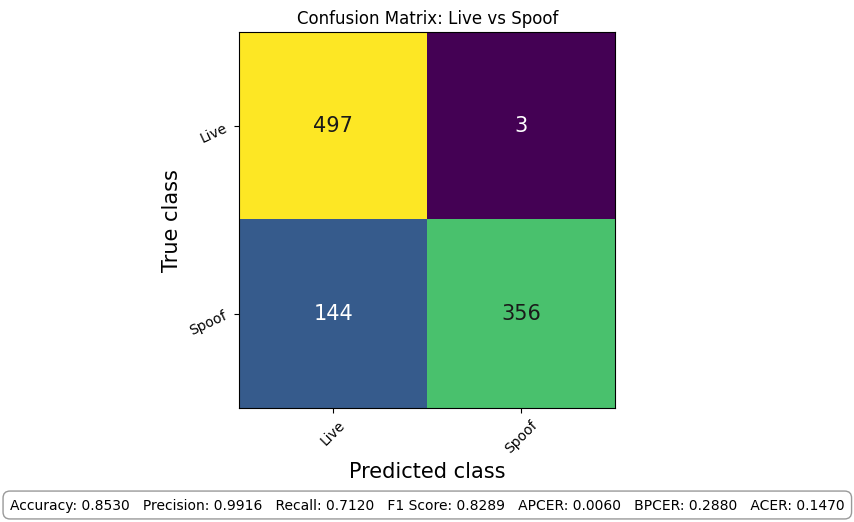

Accuracy: 0.8530
Precision: 0.9916
Recall:    0.7120
F1 Score:  0.8289
Spoofing Metrics: APCER: 0.0060, BPCER: 0.2880, ACER: 0.1470


(<Figure size 640x480 with 1 Axes>,
 tensor(0.8530, device='cuda:0'),
 tensor(0.9916, device='cuda:0'),
 tensor(0.7120, device='cuda:0'),
 tensor(0.8289, device='cuda:0'),
 {'APCER': tensor(0.0060, device='cuda:0'),
  'BPCER': tensor(0.2880, device='cuda:0'),
  'ACER': tensor(0.1470, device='cuda:0')})

In [18]:
evaluate_model(
    model=model,
    dataloader=small_test_loader,
    device=device,
    val_transforms=gpu_transforms_val,
    threshold=0.5,
    final_activation="argmax"
)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           497     |          3
Spoof          103     |        397


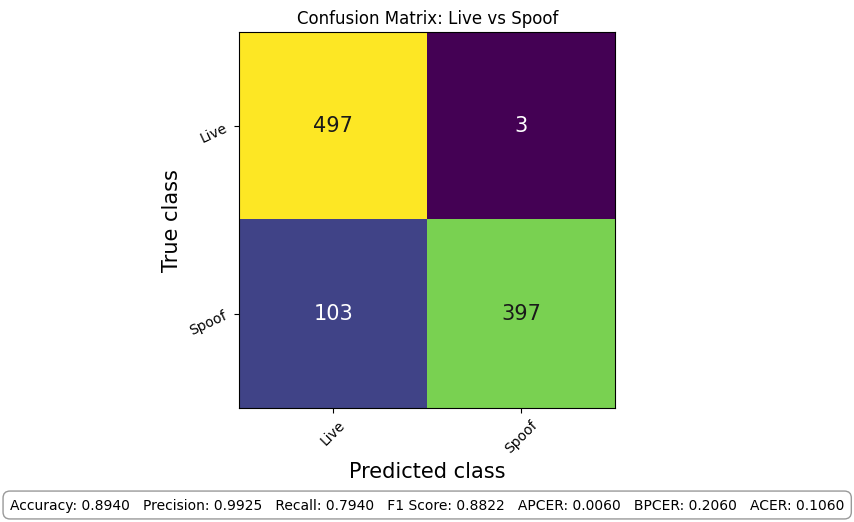

Accuracy: 0.8940
Precision: 0.9925
Recall:    0.7940
F1 Score:  0.8822
Spoofing Metrics: APCER: 0.0060, BPCER: 0.2060, ACER: 0.1060


(<Figure size 640x480 with 1 Axes>,
 tensor(0.8940, device='cuda:0'),
 tensor(0.9925, device='cuda:0'),
 tensor(0.7940, device='cuda:0'),
 tensor(0.8822, device='cuda:0'),
 {'APCER': tensor(0.0060, device='cuda:0'),
  'BPCER': tensor(0.2060, device='cuda:0'),
  'ACER': tensor(0.1060, device='cuda:0')})

In [19]:
evaluate_model(
    model=model,
    dataloader=small_test_loader,
    device=device,
    val_transforms=gpu_transforms_val,
    threshold=0.1,
    final_activation="softmax"
)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           496     |          4
Spoof           78     |        422


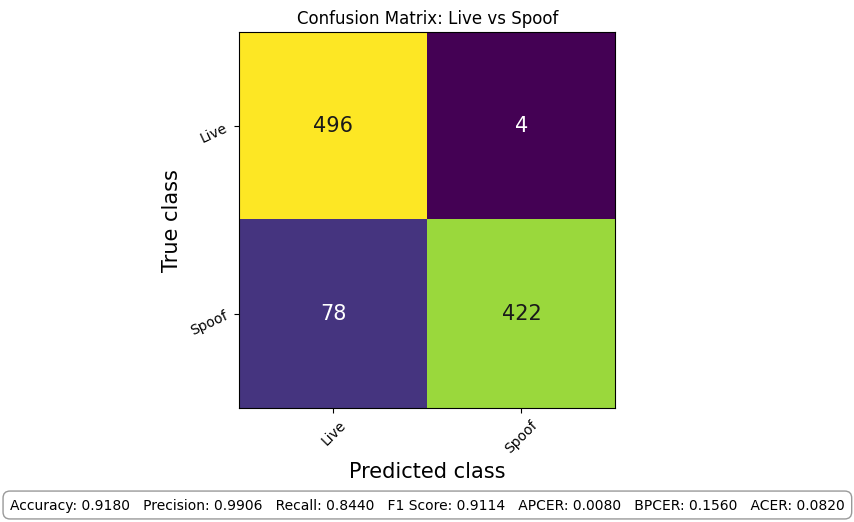

Accuracy: 0.9180
Precision: 0.9906
Recall:    0.8440
F1 Score:  0.9114
Spoofing Metrics: APCER: 0.0080, BPCER: 0.1560, ACER: 0.0820


(<Figure size 640x480 with 1 Axes>,
 tensor(0.9180, device='cuda:0'),
 tensor(0.9906, device='cuda:0'),
 tensor(0.8440, device='cuda:0'),
 tensor(0.9114, device='cuda:0'),
 {'APCER': tensor(0.0080, device='cuda:0'),
  'BPCER': tensor(0.1560, device='cuda:0'),
  'ACER': tensor(0.0820, device='cuda:0')})

In [20]:
evaluate_model(
    model=model,
    dataloader=small_test_loader,
    device=device,
    val_transforms=gpu_transforms_val,
    threshold=0.1,
    final_activation="sigmoid"
)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           496     |          4
Spoof           75     |        425


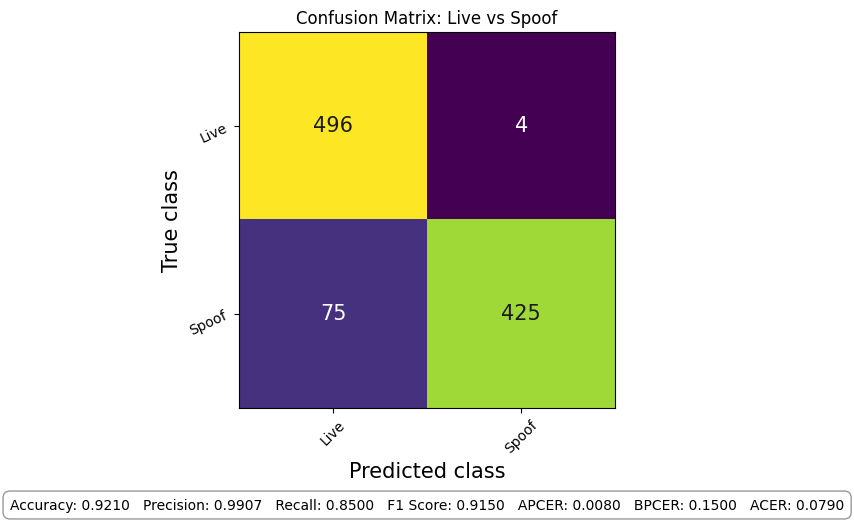

Accuracy: 0.9210
Precision: 0.9907
Recall:    0.8500
F1 Score:  0.9150
Spoofing Metrics: APCER: 0.0080, BPCER: 0.1500, ACER: 0.0790
AUROC: 0.9909


(<Figure size 640x480 with 1 Axes>,
 tensor(0.9210, device='cuda:0'),
 tensor(0.9907, device='cuda:0'),
 tensor(0.8500, device='cuda:0'),
 tensor(0.9150, device='cuda:0'),
 {'APCER': tensor(0.0080, device='cuda:0'),
  'BPCER': tensor(0.1500, device='cuda:0'),
  'ACER': tensor(0.0790, device='cuda:0')})

In [ ]:
from torchmetrics.classification import (
    MulticlassConfusionMatrix,
    Accuracy,
    Precision,
    Recall,
    F1Score,
    AUROC
)
from spoofdet.spoofing_metric import SpoofingMetric


def evaluate_model(
    model,
    dataloader: DataLoader,
    device: torch.device,
    val_transforms: v2.Compose | None = None,
    threshold: float = 0.5,
):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    spoof_metric = SpoofingMetric().to(device)
    auroc_metric = AUROC(task='binary').to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            images = val_transforms(images)
            outputs = model(images)
            
            # FIX: Use Softmax for 2-class logits, not Sigmoid
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Class 1 is 'Spoof'. We compare prob(Spoof) > threshold
            preds = (probs[:, 1] > threshold).long()

            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)
            spoof_metric.update(preds, labels)
            auroc_metric.update(probs[:, 1], labels)

    # Compute the final results
    final_matrix = confmat.compute()
    print("\nConfusion Matrix:")
    print(f"         Predicted Live | Predicted Spoof")
    print(f"Live        {final_matrix[0,0]:>6}     |     {final_matrix[0,1]:>6}")
    print(f"Spoof       {final_matrix[1,0]:>6}     |     {final_matrix[1,1]:>6}")
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()
    spoof_metric_val = spoof_metric.compute()
    auroc_val = auroc_metric.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")

    # Add metrics as text below the matrix
    metrics_text = (
        f"Accuracy: {acc_val:.4f}   "
        f"Precision: {prec_val:.4f}   "
        f"Recall: {rec_val:.4f}   "
        f"F1 Score: {f1_val:.4f}   "
        f"APCER: {spoof_metric_val['APCER']:.4f}   "
        f"BPCER: {spoof_metric_val['BPCER']:.4f}   "
        f"ACER: {spoof_metric_val['ACER']:.4f}"
    )

    # Position the text at the bottom center of the figure
    fig.text(
        0.5,
        -0.05,
        metrics_text,
        ha="center",
        fontsize=10,
        bbox=dict(
            facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5"
        ),
    )

    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")
    print(
        f"Spoofing Metrics: APCER: {spoof_metric_val['APCER']:.4f}, BPCER: {spoof_metric_val['BPCER']:.4f}, ACER: {spoof_metric_val['ACER']:.4f}"
    )
    print(f"AUROC: {auroc_val:.4f}")

    return fig, acc_val, prec_val, rec_val, f1_val, spoof_metric_val
evaluate_model(
    model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold= 0.01)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           496     |          4
Spoof           78     |        422


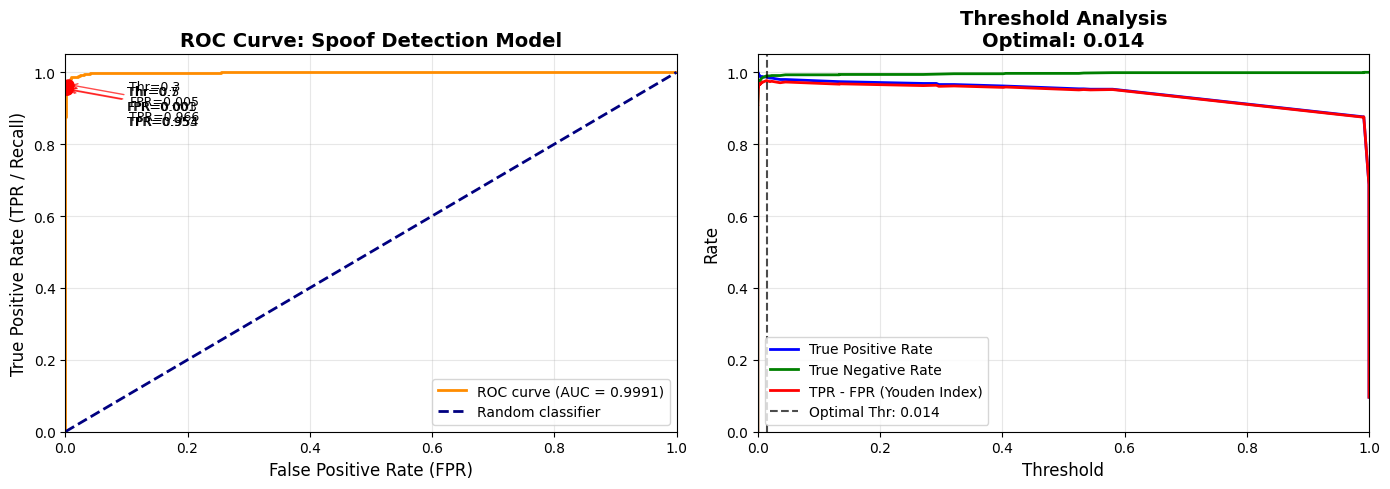

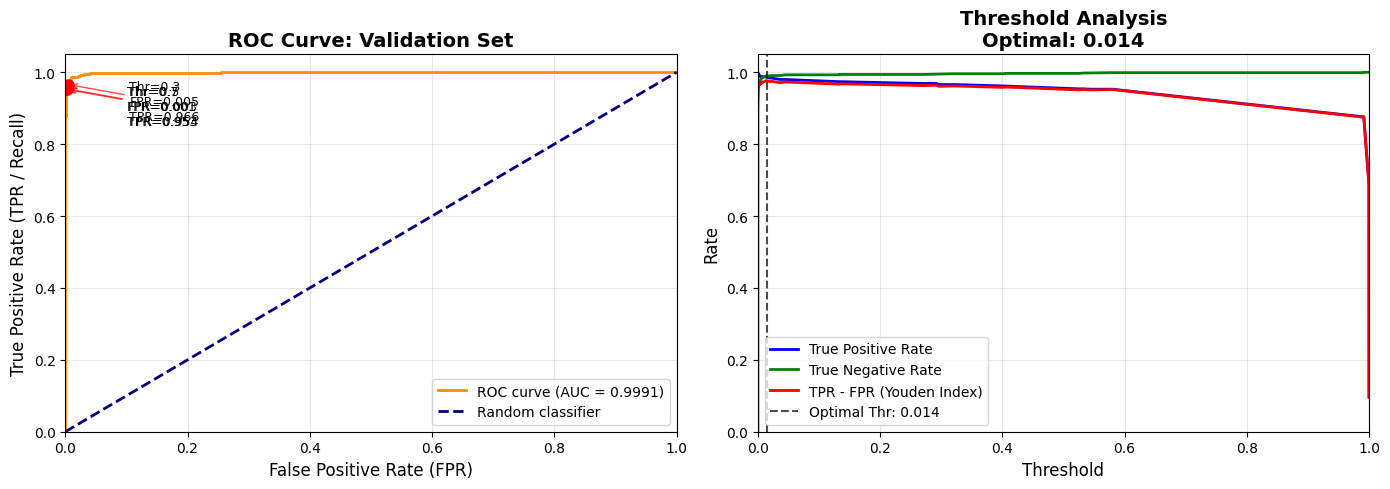

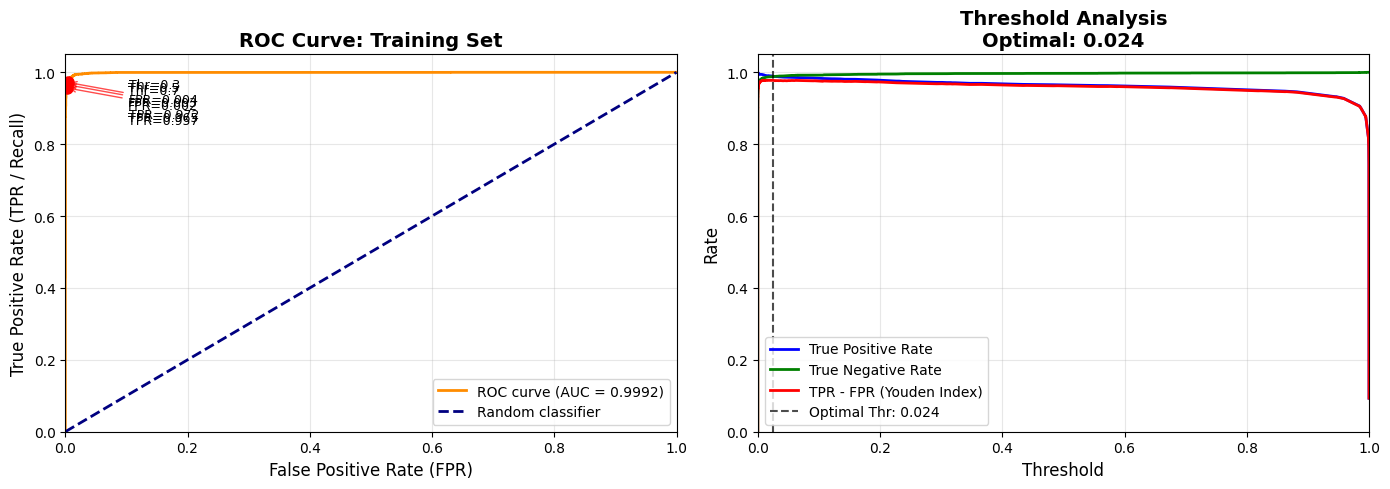

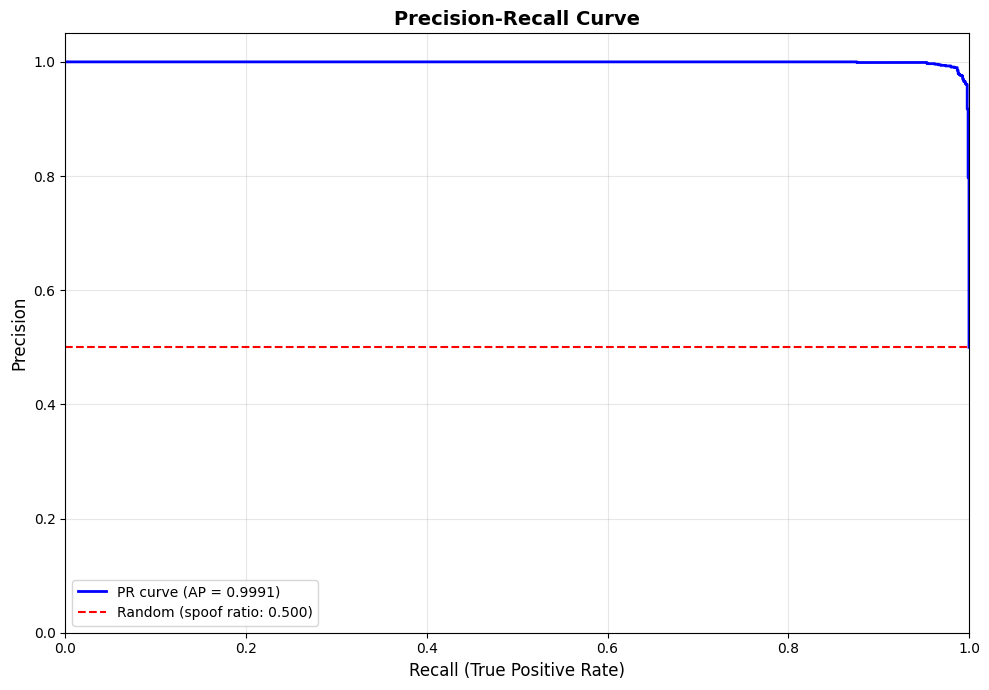

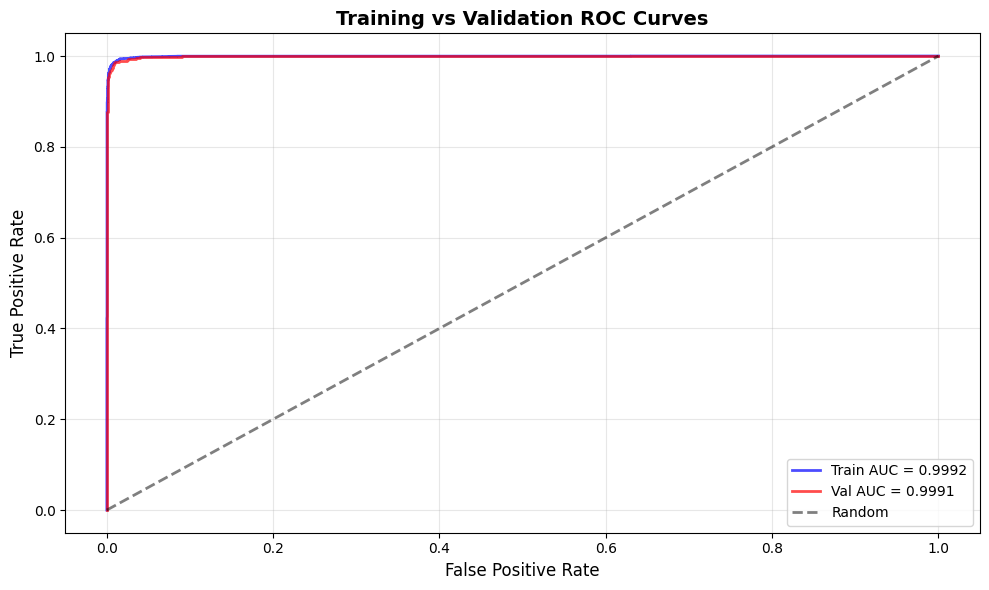

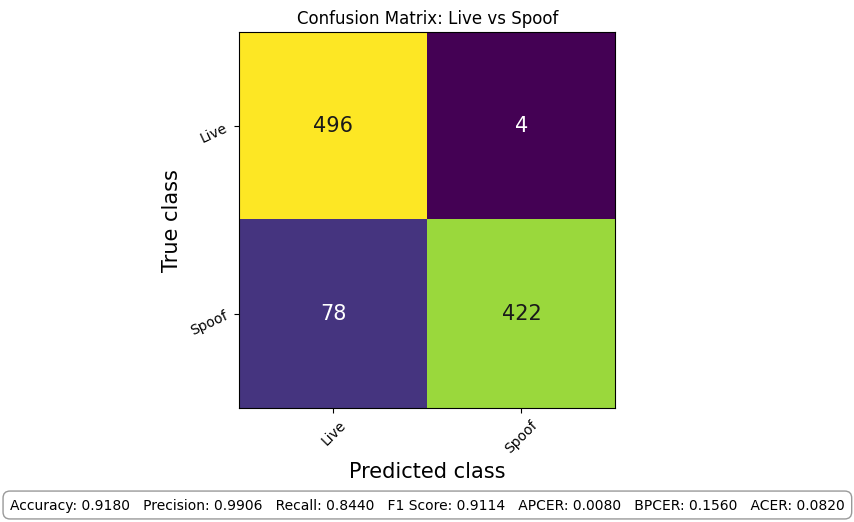

Accuracy: 0.9180
Precision: 0.9906
Recall:    0.8440
F1 Score:  0.9114
Spoofing Metrics: APCER: 0.0080, BPCER: 0.1560, ACER: 0.0820
AUROC: 0.9909


(<Figure size 640x480 with 1 Axes>,
 tensor(0.9180, device='cuda:0'),
 tensor(0.9906, device='cuda:0'),
 tensor(0.8440, device='cuda:0'),
 tensor(0.9114, device='cuda:0'),
 {'APCER': tensor(0.0080, device='cuda:0'),
  'BPCER': tensor(0.1560, device='cuda:0'),
  'ACER': tensor(0.0820, device='cuda:0')})

In [38]:
from torchmetrics.classification import (
    MulticlassConfusionMatrix,
    Accuracy,
    Precision,
    Recall,
    F1Score,
    AUROC
)
from spoofdet.spoofing_metric import SpoofingMetric


def evaluate_model(
    model,
    dataloader: DataLoader,
    device: torch.device,
    val_transforms: v2.Compose | None = None,
    threshold: float = 0.5,
):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    spoof_metric = SpoofingMetric().to(device)
    auroc_metric = AUROC(task='binary').to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            images = val_transforms(images)
            outputs = model(images)
            
            # FIX: Use Softmax for 2-class logits, not Sigmoid
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Class 1 is 'Spoof'. We compare prob(Spoof) > threshold
            preds = (probs[:, 1] > threshold).long()

            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)
            spoof_metric.update(preds, labels)
            auroc_metric.update(probs[:, 1], labels)

    # Compute the final results
    final_matrix = confmat.compute()
    print("\nConfusion Matrix:")
    print(f"         Predicted Live | Predicted Spoof")
    print(f"Live        {final_matrix[0,0]:>6}     |     {final_matrix[0,1]:>6}")
    print(f"Spoof       {final_matrix[1,0]:>6}     |     {final_matrix[1,1]:>6}")
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()
    spoof_metric_val = spoof_metric.compute()
    auroc_val = auroc_metric.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")

    # Add metrics as text below the matrix
    metrics_text = (
        f"Accuracy: {acc_val:.4f}   "
        f"Precision: {prec_val:.4f}   "
        f"Recall: {rec_val:.4f}   "
        f"F1 Score: {f1_val:.4f}   "
        f"APCER: {spoof_metric_val['APCER']:.4f}   "
        f"BPCER: {spoof_metric_val['BPCER']:.4f}   "
        f"ACER: {spoof_metric_val['ACER']:.4f}"
    )

    # Position the text at the bottom center of the figure
    fig.text(
        0.5,
        -0.05,
        metrics_text,
        ha="center",
        fontsize=10,
        bbox=dict(
            facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5"
        ),
    )

    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")
    print(
        f"Spoofing Metrics: APCER: {spoof_metric_val['APCER']:.4f}, BPCER: {spoof_metric_val['BPCER']:.4f}, ACER: {spoof_metric_val['ACER']:.4f}"
    )
    print(f"AUROC: {auroc_val:.4f}")

    return fig, acc_val, prec_val, rec_val, f1_val, spoof_metric_val
evaluate_model(
    model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold= 0.0143)

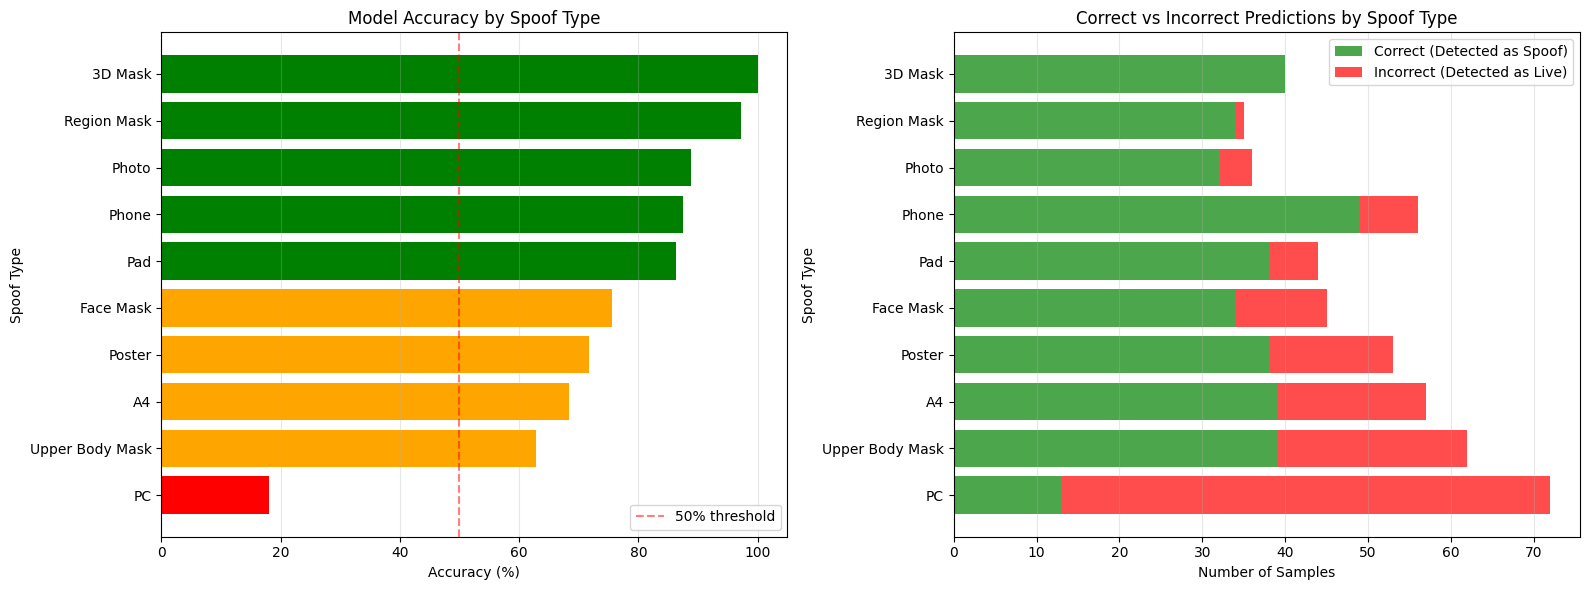


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     72       13         59     18.055556
Upper Body Mask        5     62       39         23     62.903226
             A4        3     57       39         18     68.421053
         Poster        2     53       38         15     71.698113
      Face Mask        4     45       34         11     75.555556
            Pad        8     44       38          6     86.363636
          Phone        9     56       49          7     87.500000
          Photo        1     36       32          4     88.888889
    Region Mask        6     35       34          1     97.142857
        3D Mask       10     40       40          0    100.000000


Worst Performing Spoof Types (Accuracy < 70%):
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     72       13         59     18.055556
Upper Body Mask        5     62       39         23     62.9032

(        Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
 6               PC        7     72       13         59     18.055556
 4  Upper Body Mask        5     62       39         23     62.903226
 2               A4        3     57       39         18     68.421053
 1           Poster        2     53       38         15     71.698113
 3        Face Mask        4     45       34         11     75.555556
 7              Pad        8     44       38          6     86.363636
 8            Phone        9     56       49          7     87.500000
 0            Photo        1     36       32          4     88.888889
 5      Region Mask        6     35       34          1     97.142857
 9          3D Mask       10     40       40          0    100.000000,
 <Figure size 1600x600 with 2 Axes>)

In [30]:
analyze_spoof_types(model=model, dataset=small_test_ds, device=device, val_transforms=gpu_transforms_val)

ROC AUC Score: 1.0000
ROC AUC Score: 0.9882
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 0.9921
ROC AUC Score: 0.9883
ROC AUC Score: 0.9922
ROC AUC Score: 0.9563
ROC AUC Score: 0.9740
ROC AUC Score: 0.9722
ROC AUC Score: 1.0000
ROC AUC Score: 0.9917
ROC AUC Score: 0.9961
ROC AUC Score: 0.9688
ROC AUC Score: 0.9919
ROC AUC Score: 0.9919
ROC AUC Score: 0.9727
ROC AUC Score: 1.0000
ROC AUC Score: 0.9802
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 1.0000
ROC AUC Score: 0.9591
ROC AUC Score: 1.0000


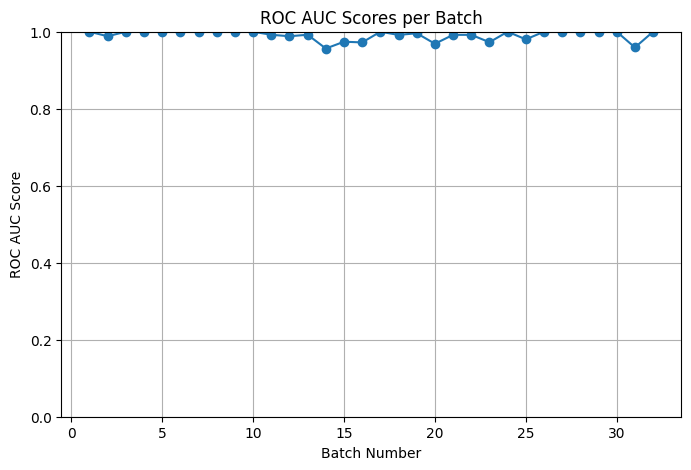

In [35]:
from sklearn.metrics import roc_auc_score

# 1. Get your probabilities (Make sure to detach from GPU)
# probs[:, 1] extracts the score for the "Spoof" class

auc_values = []
model.eval() # Ensure model is in eval mode
for img, labels in small_test_loader:
    img, labels = img.to(device), labels.to(device)
    img = gpu_transforms_val(img)

    with torch.no_grad():
        outputs = model(img)
        # Use Sigmoid for 2-class logits
        probs = torch.nn.functional.sigmoid(outputs)

    y_scores = probs[:, 1].detach().cpu().numpy()
    y_true = labels.detach().cpu().numpy()

    # 2. Compute AUC
    # Check if we have both classes in the batch, otherwise ROC AUC is undefined
    if len(np.unique(y_true)) > 1:
        auc_value = roc_auc_score(y_true, y_scores)
        auc_values.append(auc_value)
        print(f"ROC AUC Score: {auc_value:.4f}")
    else:
        print("Skipping batch (single class present)")

import matplotlib.pyplot as plt

if auc_values:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(auc_values) + 1), auc_values, marker='o')
    plt.title('ROC AUC Scores per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('ROC AUC Score')
    plt.ylim(0, 1)
    plt.grid()
    plt.show()
else:
    print("No valid AUC scores calculated.")

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_roc_auc(model, dataloader, device, val_transforms=None, title="ROC Curve"):
    """
    Plot ROC curve and calculate AUC for binary classification.
    
    Returns:
    - fpr: False Positive Rates
    - tpr: True Positive Rates
    - roc_auc: AUC score
    - fig: Matplotlib figure
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            
            # Get probabilities for spoof class (class 1)
            # Assuming model outputs logits for 2 classes
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of spoof
            # Or use sigmoid if single output: probs = torch.sigmoid(outputs).squeeze()
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Check if we have both classes
    if len(np.unique(all_labels)) < 2:
        print("Warning: Only one class present in the data.")
        return None, None, None, None
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax1.set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12)
    ax1.set_title(f'ROC Curve: {title}', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Add important thresholds
    for threshold in [0.3, 0.5, 0.7]:
        idx = np.argmin(np.abs(thresholds - threshold))
        ax1.plot(fpr[idx], tpr[idx], 'ro', markersize=8)
        ax1.annotate(f'Thr={threshold:.1f}\nFPR={fpr[idx]:.3f}\nTPR={tpr[idx]:.3f}',
                    xy=(fpr[idx], tpr[idx]),
                    xytext=(fpr[idx]+0.1, tpr[idx]-0.1),
                    fontsize=9,
                    arrowprops=dict(arrowstyle="->", color='red', alpha=0.7))
    
    # 2. Threshold Analysis (Spacing threshold)
    ax2.plot(thresholds, tpr, 'b-', lw=2, label='True Positive Rate')
    ax2.plot(thresholds, 1-fpr, 'g-', lw=2, label='True Negative Rate')
    ax2.plot(thresholds, tpr - fpr, 'r-', lw=2, label='TPR - FPR (Youden Index)')
    
    # Find optimal threshold (Youden's J statistic)
    youden_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[youden_idx]
    optimal_tpr = tpr[youden_idx]
    optimal_fpr = fpr[youden_idx]
    
    ax2.axvline(x=optimal_threshold, color='k', linestyle='--', alpha=0.7,
                label=f'Optimal Thr: {optimal_threshold:.3f}')
    
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Rate', fontsize=12)
    ax2.set_title(f'Threshold Analysis\nOptimal: {optimal_threshold:.3f}', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    
    # Print statistics
    print("\n" + "="*60)
    print("ROC-AUC ANALYSIS")
    print("="*60)
    print(f"AUC Score: {roc_auc:.6f}")
    print(f"Optimal Threshold (Youden): {optimal_threshold:.4f}")
    print(f"At optimal threshold:")
    print(f"  - True Positive Rate (Recall): {optimal_tpr:.4f}")
    print(f"  - False Positive Rate: {optimal_fpr:.4f}")
    print(f"  - False Negative Rate: {1-optimal_tpr:.4f}")
    print(f"  - True Negative Rate: {1-optimal_fpr:.4f}")
    
    return fig, fpr, tpr, roc_auc, optimal_threshold


def plot_precision_recall_curve(model, dataloader, device, val_transforms=None):
    """
    Plot Precision-Recall curve for imbalanced datasets.
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Spoof probability
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot PR curve
    ax.plot(recall, precision, color='blue', lw=2, 
            label=f'PR curve (AP = {avg_precision:.4f})')
    
    # Baseline (random classifier)
    spoof_ratio = np.mean(all_labels)
    ax.axhline(y=spoof_ratio, color='red', linestyle='--', 
               label=f'Random (spoof ratio: {spoof_ratio:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    print(f"\nAverage Precision (AP): {avg_precision:.6f}")
    print(f"Spoof ratio in dataset: {spoof_ratio:.4f}")
    
    return fig, precision, recall, avg_precision


def comprehensive_evaluation(model, train_loader, val_loader, device, 
                           train_transforms=None, val_transforms=None):
    """
    Comprehensive evaluation with ROC, PR curves, and confusion matrices.
    """
    print("="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*70)
    
    # 1. Evaluate on validation set
    print("\n1. Validation Set Evaluation:")
    fig_val, fpr_val, tpr_val, auc_val, opt_thr_val = plot_roc_auc(
        model, val_loader, device, val_transforms, "Validation Set"
    )
    
    # 2. Evaluate on training set (check overfitting)
    print("\n2. Training Set Evaluation (Check Overfitting):")
    fig_train, fpr_train, tpr_train, auc_train, _ = plot_roc_auc(
        model, train_loader, device, train_transforms, "Training Set"
    )
    
    # 3. Precision-Recall curve
    print("\n3. Precision-Recall Analysis:")
    fig_pr, precision, recall, avg_precision = plot_precision_recall_curve(
        model, val_loader, device, val_transforms
    )
    
    # 4. Calculate metrics at optimal threshold
    print("\n4. Performance at Optimal Threshold:")
    if opt_thr_val is not None:
        # Re-evaluate with optimal threshold
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                if val_transforms is not None:
                    images = val_transforms(images)
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = (probs > opt_thr_val).long()
                
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        from sklearn.metrics import classification_report, confusion_matrix
        
        print(f"\nClassification Report (Threshold = {opt_thr_val:.3f}):")
        print(classification_report(all_labels, all_preds, 
                                    target_names=['Live', 'Spoof']))
        
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Confusion Matrix:")
        print(f"               Predicted Live  |  Predicted Spoof")
        print(f"Actual Live:    {cm[0,0]:6d}            {cm[0,1]:6d}")
        print(f"Actual Spoof:   {cm[1,0]:6d}            {cm[1,1]:6d}")
    
    # 5. Compare training vs validation AUC (overfitting check)
    print("\n5. Overfitting Analysis:")
    print(f"Training AUC:   {auc_train:.6f}")
    print(f"Validation AUC: {auc_val:.6f}")
    print(f"Difference:     {abs(auc_train - auc_val):.6f}")
    
    if auc_train - auc_val > 0.05:
        print("⚠️  Warning: Possible overfitting (train AUC > val AUC by > 0.05)")
    
    # Create comparison figure
    fig_compare, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr_train, tpr_train, 'b-', lw=2, alpha=0.7, 
            label=f'Train AUC = {auc_train:.4f}')
    ax.plot(fpr_val, tpr_val, 'r-', lw=2, alpha=0.7, 
            label=f'Val AUC = {auc_val:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('Training vs Validation ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return {
        'val_auc': auc_val,
        'train_auc': auc_train,
        'optimal_threshold': opt_thr_val,
        'avg_precision': avg_precision,
        'figures': {
            'roc_val': fig_val,
            'roc_train': fig_train,
            'pr_curve': fig_pr,
            'comparison': fig_compare
        }
    }

# Simple ROC plot for your validation set
fig, fpr, tpr, auc_score, opt_threshold = plot_roc_auc(
    model=model,
    dataloader=small_val_loader,
    device=device,
    val_transforms=gpu_transforms_val,
    title="Spoof Detection Model"
)

# Or comprehensive evaluation
results = comprehensive_evaluation(
    model=model,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    device=device,
    train_transforms=gpu_transforms_train,
    val_transforms=gpu_transforms_val
)

# Save the best figure
results['figures']['roc_val'].savefig('roc_curve.png', dpi=300, bbox_inches='tight')


ROC-AUC ANALYSIS
AUC Score: 0.999070
Optimal Threshold (Youden): 0.0143
At optimal threshold:
  - True Positive Rate (Recall): 0.9870
  - False Positive Rate: 0.0100
  - False Negative Rate: 0.0130
  - True Negative Rate: 0.9900
COMPREHENSIVE MODEL EVALUATION

1. Validation Set Evaluation:

ROC-AUC ANALYSIS
AUC Score: 0.999070
Optimal Threshold (Youden): 0.0143
At optimal threshold:
  - True Positive Rate (Recall): 0.9870
  - False Positive Rate: 0.0100
  - False Negative Rate: 0.0130
  - True Negative Rate: 0.9900

2. Training Set Evaluation (Check Overfitting):

ROC-AUC ANALYSIS
AUC Score: 0.999234
Optimal Threshold (Youden): 0.0244
At optimal threshold:
  - True Positive Rate (Recall): 0.9894
  - False Positive Rate: 0.0116
  - False Negative Rate: 0.0106
  - True Negative Rate: 0.9884

3. Precision-Recall Analysis:

Average Precision (AP): 0.999125
Spoof ratio in dataset: 0.5000

4. Performance at Optimal Threshold:

Classification Report (Threshold = 0.014):
              precisi

Analyzing spoof type distribution...


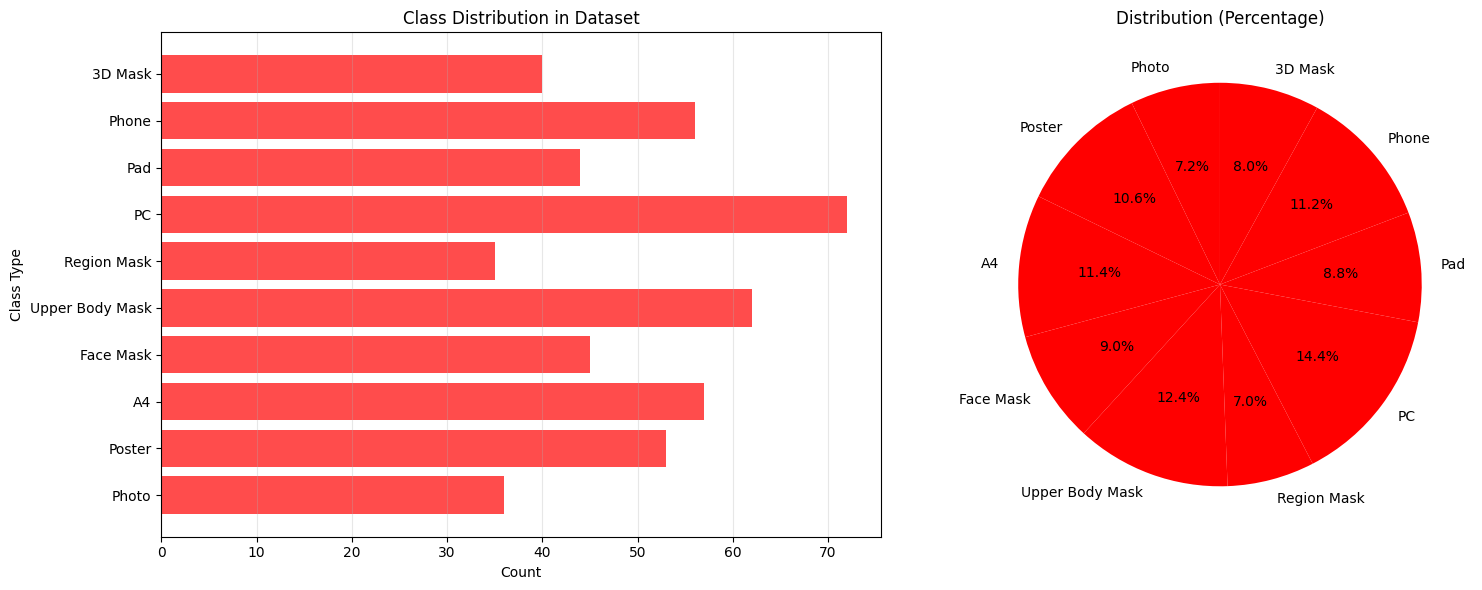


Class Distribution:
     Spoof Type  Type ID  Count  Percentage
          Photo        1     36         3.6
         Poster        2     53         5.3
             A4        3     57         5.7
      Face Mask        4     45         4.5
Upper Body Mask        5     62         6.2
    Region Mask        6     35         3.5
             PC        7     72         7.2
            Pad        8     44         4.4
          Phone        9     56         5.6
        3D Mask       10     40         4.0


In [23]:
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_test_ds)